# Zillow House Price Prediction Linear Models

**Introduction**

Zillow as one of the largest marketplaces for real estate information in the U.S, it’s Zestimate is a prediction of a property value. Zillow hosted a [Kaggle Competition](https://www.kaggle.com/c/zillow-prize-1/data) with over a million in prizes to get ideas to improve their Zestimate.  


In [2]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math
import h5py
import warnings
from tensorflow.python.framework import ops
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
target='logerror'
min_mem_size=6 
run_time=333

In [4]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

3


In [5]:
# 65535 Highest port no
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:19372..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-macosx) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-macosx) (build 25.121-b15, mixed mode)
  Starting server from /Users/bear/anaconda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmp3p_k25uk
  JVM stdout: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmp3p_k25uk/h2o_bear_started_from_python.out
  JVM stderr: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmp3p_k25uk/h2o_bear_started_from_python.err
  Server is running at http://127.0.0.1:19372
Connecting to H2O server at http://127.0.0.1:19372... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,25 days
H2O cluster name:,H2O_from_python_bear_114ib0
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [6]:
# read the property data from properties_2016 file
data_file='kaggle_data/properties_2016_scrubbed_good.csv'

In the properties file, we can see there are 58 colunms. According to zillow data dictionary each field is as follows:
- 'airconditioningtypeid'	 Type of cooling system present in the home (if any)
- 'architecturalstyletypeid'	 Architectural style of the home (i.e. ranch, colonial, split-level, etc…)
- 'basementsqft'	 Finished living area below or partially below ground level
- 'bathroomcnt'	 Number of bathrooms in home including fractional bathrooms
- 'bedroomcnt'	 Number of bedrooms in home 
- 'buildingqualitytypeid'	 Overall assessment of condition of the building from best (lowest) to worst (highest)
- 'buildingclasstypeid'	The building framing type (steel frame, wood frame, concrete/brick) 
- 'calculatedbathnbr'	 Number of bathrooms in home including fractional bathroom
- 'decktypeid'	Type of deck (if any) present on parcel
- 'threequarterbathnbr'	 Number of 3/4 bathrooms in house (shower + sink + toilet)
- 'finishedfloor1squarefeet'	 Size of the finished living area on the first (entry) floor of the home
- 'calculatedfinishedsquarefeet'	 Calculated total finished living area of the home 
- 'finishedsquarefeet6'	Base unfinished and finished area
- 'finishedsquarefeet12'	Finished living area
- 'finishedsquarefeet13'	Perimeter  living area
- 'finishedsquarefeet15'	Total area
- 'finishedsquarefeet50'	 Size of the finished living area on the first (entry) floor of the home
- 'fips'	 Federal Information Processing Standard code -  see https://en.wikipedia.org/wiki/FIPS_county_code for more details
- 'fireplacecnt'	 Number of fireplaces in a home (if any)
- 'fireplaceflag'	 Is a fireplace present in this home 
- 'fullbathcnt'	 Number of full bathrooms (sink, shower + bathtub, and toilet) present in home
- 'garagecarcnt'	 Total number of garages on the lot including an attached garage
- 'garagetotalsqft'	 Total number of square feet of all garages on lot including an attached garage
- 'hashottuborspa'	 Does the home have a hot tub or spa
- 'heatingorsystemtypeid'	 Type of home heating system
- 'latitude'	 Latitude of the middle of the parcel multiplied by 10e6
- 'longitude'	 Longitude of the middle of the parcel multiplied by 10e6
- 'lotsizesquarefeet'	 Area of the lot in square feet
- 'numberofstories'	 Number of stories or levels the home has
- 'parcelid'	 Unique identifier for parcels (lots) 
- 'poolcnt'	 Number of pools on the lot (if any)
- 'poolsizesum'	 Total square footage of all pools on property
- 'pooltypeid10'	 Spa or Hot Tub
- 'pooltypeid2'	 Pool with Spa/Hot Tub
- 'pooltypeid7'	 Pool without hot tub
- 'propertycountylandusecode'	 County land use code i.e. it's zoning at the county level
- 'propertylandusetypeid'	 Type of land use the property is zoned for
- 'propertyzoningdesc'	 Description of the allowed land uses (zoning) for that property
- 'rawcensustractandblock'	 Census tract and block ID combined - also contains blockgroup assignment by extension
- 'censustractandblock'	 Census tract and block ID combined - also contains blockgroup assignment by extension
- 'regionidcounty'	County in which the property is located
- 'regionidcity'	 City in which the property is located (if any)
- 'regionidzip'	 Zip code in which the property is located
- 'regionidneighborhood'	Neighborhood in which the property is located
- 'roomcnt'	 Total number of rooms in the principal residence
- 'storytypeid'	 Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.).  See tab for details.
- 'typeconstructiontypeid'	 What type of construction material was used to construct the home
- 'unitcnt'	 Number of units the structure is built into (i.e. 2 = duplex, 3 = triplex, etc...)
- 'yardbuildingsqft17'	Patio in  yard
- 'yardbuildingsqft26'	Storage shed/building in yard
- 'yearbuilt'	 The Year the principal residence was built 
- 'taxvaluedollarcnt'	The total tax assessed value of the parcel
- 'structuretaxvaluedollarcnt'	The assessed value of the built structure on the parcel
- 'landtaxvaluedollarcnt'	The assessed value of the land area of the parcel
- 'taxamount'	The total property tax assessed for that assessment year
- 'assessmentyear'	The year of the property tax assessment 
- 'taxdelinquencyflag'	Property taxes for this parcel are past due as of 2015
- 'taxdelinquencyyear'	Year for which the unpaid propert taxes were due 

Obviously, we can not use every column of data. Because some data has too many missing values, some data is not suitable for the prediction and some data can be calculated by some other data. So we need to do the data cleaning.

In [7]:
hf = h2o.import_file(data_file)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [8]:
hf.head()

logerror,regionidneighborhood,garagetotalsqft,finishedsquarefeet12,structuretaxvaluedollarcnt,yearbuilt,taxamount,calculatedfinishedsquarefeet,taxvaluedollarcnt,landtaxvaluedollarcnt,latitude,finishedsquarefeet15,lotsizesquarefeet,propertyzoningdesc,bedroomcnt,longitude,yardbuildingsqft17,finishedsquarefeet6,bathroomcnt,calculatedbathnbr,buildingqualitytypeid,fullbathcnt,regionidcity,propertycountylandusecode,heatingorsystemtypeid,parcelid,regionidzip,taxdelinquencyyear
0.0953,nan,0,1264,115087,1986,2015.06,1264,191811,76724,3.43036e+07,nan,1735,nan,3,-1.19287e+08,128,nan,2.5,2.5,nan,2,34543,1128,nan,1.70738e+07,97081,nan
0.0198,nan,0,777,143809,1990,2581.3,777,239679,95870,3.42729e+07,nan,nan,nan,2,-1.19199e+08,198,nan,1,1,nan,1,34543,1129,nan,1.7089e+07,97083,nan
0.006,nan,441,1101,33619,1956,591.64,1101,47853,14234,3.43408e+07,nan,6569,nan,3,-1.1908e+08,nan,nan,2,2,nan,2,26965,1111,nan,1.71004e+07,97113,nan
-0.0566,nan,460,1554,45609,1965,682.78,1554,62914,17305,3.43543e+07,nan,7400,nan,2,-1.19076e+08,nan,nan,1.5,1.5,nan,1,26965,1110,nan,1.71024e+07,97113,nan
0.0573,nan,665,2415,277000,1984,5886.92,2415,554000,277000,3.42666e+07,nan,6326,nan,4,-1.19165e+08,nan,nan,2.5,2.5,nan,2,34543,1111,nan,1.71096e+07,97084,nan
0.0564,nan,473,2882,222070,1980,3110.44,2882,289609,67539,3.424e+07,nan,10000,nan,4,-1.19025e+08,nan,nan,2.5,2.5,nan,2,51239,1111,nan,1.71258e+07,97089,nan
0.0315,nan,467,1772,185000,1978,5632.2,1772,526000,341000,3.42268e+07,nan,8059,nan,3,-1.1906e+08,1045,nan,2,2,nan,2,51239,1111,nan,1.71329e+07,97089,nan
0.0257,nan,440,2632,342611,1971,6109.94,2632,571086,228475,3.42298e+07,nan,7602,nan,5,-1.1905e+08,180,nan,2.5,2.5,nan,2,51239,1111,nan,1.71349e+07,97089,nan
0.002,nan,494,1292,231297,1979,5026.4,1292,462594,231297,3.42264e+07,nan,7405,nan,3,-1.18984e+08,304,nan,2,2,nan,2,51239,1111,nan,1.714e+07,97091,nan
-0.0576,nan,253,1385,134251,1950,3217.06,1385,268502,134251,3.41793e+07,nan,6000,nan,3,-1.19169e+08,nan,nan,1,1,nan,1,13150,1111,nan,1.71674e+07,97104,nan


In [9]:
hf.describe()

Rows:90275
Cols:28




,logerror,regionidneighborhood,garagetotalsqft,finishedsquarefeet12,structuretaxvaluedollarcnt,yearbuilt,taxamount,calculatedfinishedsquarefeet,taxvaluedollarcnt,landtaxvaluedollarcnt,latitude,finishedsquarefeet15,lotsizesquarefeet,propertyzoningdesc,bedroomcnt,longitude,yardbuildingsqft17,finishedsquarefeet6,bathroomcnt,calculatedbathnbr,buildingqualitytypeid,fullbathcnt,regionidcity,propertycountylandusecode,heatingorsystemtypeid,parcelid,regionidzip,taxdelinquencyyear
type,real,enum,enum,int,int,int,real,int,int,int,int,enum,real,enum,int,int,enum,enum,real,real,int,int,int,int,int,int,int,enum
mins,-4.605,,,2.0,100.0,1885.0,49.08,2.0,22.0,22.0,33339295.0,,167.0,,0.0,-119447865.0,,,0.0,1.0,1.0,1.0,3491.0,0.0,1.0,10711738.0,95982.0,
mean,0.011457219606757128,,,1745.454530585541,180093.39374826188,1968.532870116959,5983.975926730108,1773.1859865645993,457672.627356714,278335.3250216009,34005410.6936915,,29110.164176624017,,3.0318692882857943,-118198868.30685131,,,2.2794738299639983,2.3092162122725703,5.565406875392232,2.2412310731482834,33761.332851071515,202.69972340281998,3.9269793152639085,12984656.108712273,96586.13118351066,
maxs,4.737,,,20013.0,9948100.0,2015.0,321936.09,22741.0,27750000.0,24500000.0,34816009.0,,6971010.0,,16.0,-117554924.0,,,20.0,20.0,12.0,20.0,396556.0,8800.0,24.0,162960842.0,399675.0,
sigma,0.16107883536718667,,,909.9411657489275,209129.8881686003,23.76347471454321,6838.876956292306,928.1623927208238,554884.3989425416,400495.4648926157,264965.37555690215,,121721.30865440045,,1.156435519867552,360603.19970355305,,,1.0042709877071896,0.9761724992343215,1.9006016285969718,0.9631416217273225,46672.3938629122,307.471526829543,3.68438205053138,2504510.488301769,3661.339093751153,
zeros,847,,,0,0,0,0,0,0,0,0,,0,,1421,0,,,1165,0,0,0,0,1,0,0,0,
missing,0,0,0,4679,380,756,6,661,1,1,0,0,10150,0,0,0,0,0,0,1182,32911,1182,1803,16160,34195,0,35,0
0,0.0953,nan,0.0,1264.0,115087.0,1986.0,2015.06,1264.0,191811.0,76724.0,34303597.0,nan,1735.0,nan,3.0,-119287236.0,128.0,nan,2.5,2.5,nan,2.0,34543.0,1128.0,nan,17073783.0,97081.0,nan
1,0.0198,nan,0.0,777.0,143809.0,1990.0,2581.3,777.0,239679.0,95870.0,34272866.0,nan,nan,nan,2.0,-119198911.0,198.0,nan,1.0,1.0,nan,1.0,34543.0,1129.0,nan,17088994.0,97083.0,nan
2,0.006,nan,441.0,1101.0,33619.0,1956.0,591.64,1101.0,47853.0,14234.0,34340801.0,nan,6569.0,nan,3.0,-119079610.0,nan,nan,2.0,2.0,nan,2.0,26965.0,1111.0,nan,17100444.0,97113.0,nan


In [10]:
# First convert to a pandas df, then to a numpy array
logerror_array = hf['logerror'].as_data_frame().as_matrix()

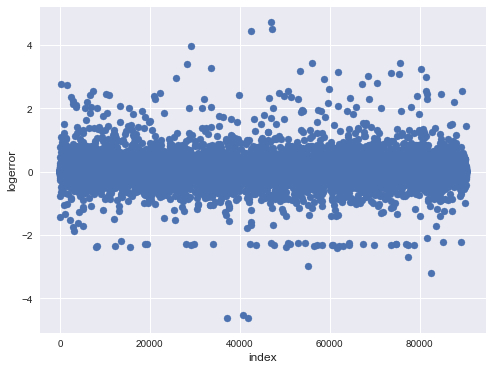

In [11]:
# show the graph of logerror 
plt.figure(figsize=(8,6))
plt.scatter(range(logerror_array.shape[0]), np.sort(logerror_array))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

In [12]:
logerror_mean=hf['logerror'].mean()[0]
print(logerror_mean)

0.011457219606757128


In [13]:
hf['logerror_highlow'] = (hf['logerror'] >= logerror_mean).ifelse("1", "0")

In [14]:
hf['logerror_highlow'].head()

logerror_highlow
1
1
0
0
1
1
1
1
0
0


In [15]:
hf['logerror_highlow'].table()

logerror_highlow,Count
0,50087
1,40188


In [16]:
logerror_range=[hf['logerror'].min(),hf['logerror'].max()]
print(logerror_range)

[-4.605, 4.737]


In [17]:
logerror_sd=hf['logerror'].sd()[0]
print(logerror_sd)

0.16107883536718667


In [18]:
top_by_pct=(0.66*(logerror_range[1]-logerror_range[0]))+logerror_range[0]
print(top_by_pct)

1.5607199999999999


In [19]:
bottom_by_pct=(0.33*(logerror_range[1]-logerror_range[0]))+logerror_range[0]
print(bottom_by_pct)

-1.5221400000000003


In [20]:
hf['logerror_three']=(hf['logerror'] <= (logerror_mean-logerror_sd)).ifelse('0','1')
hf['logerror_three'] = (hf['logerror'] >= (logerror_mean+logerror_sd)).ifelse('2', hf['logerror_three'])

In [21]:
hf['logerror_three'].head()

logerror_three
1
1
1
1
1
1
1
1
1
1


In [22]:
hf['logerror_three'].table()

logerror_three,Count
0,3616
1,82367
2,4292


In [23]:
train, valid = hf.split_frame([0.9])

In [24]:
def get_independent_variables(df, l):
    C = [name for name in df.columns if name not in l]
    # determine column types
    print (C) 
    print (df.columns)     
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x

In [25]:
y=target
X=get_independent_variables(train,y)
print(X)
print(len(X))
print(y)

['regionidneighborhood', 'garagetotalsqft', 'finishedsquarefeet12', 'structuretaxvaluedollarcnt', 'yearbuilt', 'taxamount', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'latitude', 'finishedsquarefeet15', 'lotsizesquarefeet', 'propertyzoningdesc', 'bedroomcnt', 'longitude', 'yardbuildingsqft17', 'finishedsquarefeet6', 'bathroomcnt', 'calculatedbathnbr', 'buildingqualitytypeid', 'fullbathcnt', 'regionidcity', 'propertycountylandusecode', 'heatingorsystemtypeid', 'parcelid', 'regionidzip', 'taxdelinquencyyear', 'logerror_highlow', 'logerror_three']
['logerror', 'regionidneighborhood', 'garagetotalsqft', 'finishedsquarefeet12', 'structuretaxvaluedollarcnt', 'yearbuilt', 'taxamount', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'latitude', 'finishedsquarefeet15', 'lotsizesquarefeet', 'propertyzoningdesc', 'bedroomcnt', 'longitude', 'yardbuildingsqft17', 'finishedsquarefeet6', 'bathroomcnt', 'calculatedbathnbr', 'buildingqual

## GLM Parameters


_Model parameters_ 

**Family**
The probability distribution of the dependent variable. For regression the choices are gaussian, poisson,gamma, and tweedie.

for logistic regression (i.e., binomial classification) you must set this to binomial, and for multinomial regression you must set this to multinomial.

Family defines how the deviance metric is calculated; it is only the same as MSE when the family is gaussian.


**Link**

Link defines the error model.  

Can be one of “family_default,” “identity,” “logit,” “log,” “inverse,” or “tweedie.”

As the name suggests, “family_default” is the default, and is usually best.  For example, when the dependent variable is gaussian the “family_default” is “identity“ and this is simple linear regression.


See [Simple Linear Regression and Confidence Intervals (13:01)](https://www.youtube.com/watch?v=PsE9UqoWtS4)   
and

[Multiple Linear Regression and Interpreting Regression Coefficients (15:38)](https://www.youtube.com/watch?v=1hbCJyM9ccs)

and

[Model Selection and Qualitative Predictors (14:51)](https://www.youtube.com/watch?v=3T6RXmIHbJ4)

and

[Logistic Regression and Maximum Likelihood (9:07)](https://www.youtube.com/watch?v=31Q5FGRnxt4)  

_Regularization parameters_  


The other parameters are about regularization. There are two types: L1 (also called lasso regularization or lasso regression) and L2 (i.e. ridge regression).   



L1 regularization will set some of your coefficients to zero (this can be useful to simplify a problem when you have a lot of predictor columns but don’t know which ones are important), whereas L2 regularization
tries to keep all the coefficients close to zero, but nonzero, stopping any single coefficient from dominating. If your data is dense (meaning all columns are likely to explain something about the response variable), L2 regularization is likely to be better than L1.

You choose lasso regression by setting alpha to 1.0, and you choose ridge regression by setting alpha to 0.0.  

Or you can choose elastic net, which is “have your cake and
eat it”: you set alpha between 0.0 and 1.0 to mix them together. The other parameter is lambda. While alpha decides what type of regularization to use, lambda decides how strong to make it.

See [Shrinkage Methods and Ridge Regression (12:37)](https://www.youtube.com/watch?v=cSKzqb0EKS0)

**alpha**

Described earlier, it is how much L1 regularization, and 1-alpha is how much L2 regularization. The default is 0.5.

**lambda**

Regularization strength. The default is chosen based on lambda max (described under lambda_search) but, as already mentioned, it is often useful to try lambda search to automatically find a good value. If you want to explicitly choose values for lambda that lambda search should try, specify them as a list here.


**lambda_search**

If true, then it will try multiple values of lambda for you. It starts with the maximum value of lambda, which is a lambda value such that the regularization causes all coefficients to end up as zero. It then keeps reducing the lambda value until the minimum value (which is decided by lambda_min_ratio). Note that when setting lambda_search to true you would never also set lambda to a single value. Normally you would not set lambda at all, but if you wanted to explicitly
give 2+ values for lambda

**lambda_min_ratio**

Minimum lambda used in lambda search, specified as a percentage of the starting (maximum) lambda. Defaults to 0.0001. For example, if lambda search chooses 15 as the starting value, then 0.0015 is the final lambda value it will try. Lambda search will never try a lambda of zero. If you suspect it may be best (e.g., the best value from lambda search was the final and smallest one), you will need to try it separately.

**nlambdas**


Number of lambdas to be used in a search. The default of –1 normally means it will try 100 lambdas but when doing ridge regression, i.e., alpha=0.0, it instead defaults to 30 lambdas. Consider setting this to a lower number if you need to speed things up.


**max_active_predictors**  

The default of –1 means no restriction, but you can set it to have lambda_search stop early, once it has reached this number of nonzero coefficients.


_Solvers_  

**AUTO**

AUTO will set the solver based on given data and the other parameters.  

**IRLSM**

This stands for Iterative Re-weighted Least Squares Method. If you have only a relatively small number of columns it is usually the best choice. 

**L_BFGS**

The L is for limited memory, and the BFGS is for the Broyden–Fletcher–Goldfarb– Shanno algorithm. 

_Solver parameters_  


**max_iterations**

This controls how much work the solver will do. It defaults to 50.

**beta_epsilon**  

This is for the IRLSM solver: if the beta changes less than this, then stop.


**gradient_epsilon**

This is for the L-BFGS solver: if the objective changes less than this, then stop.

**objective_epsilon**

Stop when the objective value changes less than this.


_Data parameters_  


**non_negative**

Restrict coefficients (not intercept) to be nonnegative.

**remove_collinear_columns**

Remove some of the columns, if any are linearly dependent. False by default. There is no need to set this if using regularization.  


**standardize**
Standardize numeric columns to have zero mean and unit variance. This is true by default. You are unlikely to need to set it to false, but always make sure it is true if using regularization (i.e., lambda > 0).

**missing_values_handling**

The default is “MeanImputation,” which gives them the mean value from that
column. The alternative is “Skip” to ignore rows with missing values.


**interactions**

This is a list of columns you want to interact. For example, if you give three columns, such as A, B, and C, then AB, AC, and BC will be added to your model.

See [Interactions and Nonlinearity (14:16)](https://www.youtube.com/watch?v=IFzVxLv0TKQ)


**intercept**

Whether to include a constant term in the model. The default is true, so setting it to false effectively means force an intercept of zero.   

**obj_reg**

If you want to modify the objective function. The default of –1 means it will use 1 divided by the number of rows in your training data set.   

**prior**

Used for binomial classification, and it is the prior probability for the first of the two classes. Being a probability, it must be between 0.0 and 1.0.   

**compute_p_values**

Set this to true to have the p-values for each coefficient.  



In [26]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
help(H2OGeneralizedLinearEstimator)

Help on class H2OGeneralizedLinearEstimator in module h2o.estimators.glm:

class H2OGeneralizedLinearEstimator(h2o.estimators.estimator_base.H2OEstimator)
 |  Generalized Linear Modeling
 |  
 |  Fits a generalized linear model, specified by a response variable, a set of predictors, and a
 |  description of the error distribution.
 |  
 |  A subclass of :class:`ModelBase` is returned. The specific subclass depends on the machine learning task
 |  at hand (if it's binomial classification, then an H2OBinomialModel is returned, if it's regression then a
 |  H2ORegressionModel is returned). The default print-out of the models is shown, but further GLM-specific
 |  information can be queried out of the object. Upon completion of the GLM, the resulting object has
 |  coefficients, normalized coefficients, residual/null deviance, aic, and a host of model metrics including
 |  MSE, AUC (for logistic regression), degrees of freedom, and confusion matrices.
 |  
 |  Method resolution order:
 |  

In [27]:
glm_gaussian_v1 = H2OGeneralizedLinearEstimator(
                    model_id='glm_gaussian_v1',           
                    family='gaussian',
                    solver='L_BFGS')

In [28]:
glm_gaussian_v1.train(X,y, training_frame=train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [29]:
glm_gaussian_v1

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  glm_gaussian_v1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.012269539491957344
RMSE: 0.11076795336177944
MAE: 0.0421434922559707
RMSLE: NaN
R^2: 0.5221880582325444
Mean Residual Deviance: 0.012269539491957344
Null degrees of freedom: 81198
Residual degrees of freedom: 75205
Null deviance: 2085.076261430717
Residual deviance: 996.2743372074444
AIC: -114904.42628620921
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2019-02-20 01:34:24,0.000 sec,0,2085.0762605,0.0256786
,2019-02-20 01:34:24,0.222 sec,1,1779.2651238,0.0219201
,2019-02-20 01:34:24,0.342 sec,2,1561.9075890,0.0192609
,2019-02-20 01:34:24,0.497 sec,3,1519.7272957,0.0187417
,2019-02-20 01:34:24,0.557 sec,4,1491.8459734,0.0184080
,2019-02-20 01:34:25,0.648 sec,5,1329.8148690,0.0164578
,2019-02-20 01:34:25,0.697 sec,6,1118.5878503,0.0139849
,2019-02-20 01:34:25,0.721 sec,7,1048.7107655,0.0131789
,2019-02-20 01:34:25,0.773 sec,8,1039.7860432,0.0130861
,2019-02-20 01:34:25,0.803 sec,9,1018.3239000,0.0128346


In [30]:
train.describe()

Rows:81199
Cols:30




,logerror,regionidneighborhood,garagetotalsqft,finishedsquarefeet12,structuretaxvaluedollarcnt,yearbuilt,taxamount,calculatedfinishedsquarefeet,taxvaluedollarcnt,landtaxvaluedollarcnt,latitude,finishedsquarefeet15,lotsizesquarefeet,propertyzoningdesc,bedroomcnt,longitude,yardbuildingsqft17,finishedsquarefeet6,bathroomcnt,calculatedbathnbr,buildingqualitytypeid,fullbathcnt,regionidcity,propertycountylandusecode,heatingorsystemtypeid,parcelid,regionidzip,taxdelinquencyyear,logerror_highlow,logerror_three
type,real,enum,enum,int,int,int,real,int,int,int,int,enum,real,enum,int,int,enum,enum,real,real,int,int,int,int,int,int,int,enum,enum,enum
mins,-4.605,,,2.0,100.0,1885.0,49.08,2.0,22.0,22.0,33339295.0,,167.0,,0.0,-119447865.0,,,0.0,1.0,1.0,1.0,3491.0,0.0,1.0,10711738.0,95982.0,,,
mean,0.011216225569280413,,,1745.3842687582785,180189.65661912953,1968.5372693177019,5986.219545773648,1772.9539240255067,457948.330660854,278533.1535875269,34005442.26407961,,29062.913969636433,,3.031798421162824,-118198834.11816648,,,2.279750982154953,2.3096141366744862,5.565504935901165,2.24156391953277,33683.95432097216,202.74086518269638,3.9226390018447623,12985977.637507854,96584.28873803388,,,
maxs,4.737,,,20013.0,9948100.0,2015.0,321936.09,22741.0,27750000.0,24500000.0,34816009.0,,6971010.0,,16.0,-117554924.0,,,20.0,20.0,12.0,20.0,396556.0,6050.0,24.0,162960842.0,399675.0,,,
sigma,0.16024640886809977,,,908.989755305141,208067.1426526782,23.765149134160815,6868.49559518842,927.5453860910411,556440.1117803449,402603.4461440696,265327.54569498595,,120887.84072477915,,1.1566394976045355,360725.5288288521,,,1.0037803036340833,0.9755370582708923,1.9017417146509352,0.9624688037648107,46433.35966844541,306.31475103913937,3.67833621976241,2505539.8944113203,3552.660167815567,,,
zeros,762,,,0,0,0,0,0,0,0,0,,0,,1282,0,,,1052,0,0,0,0,1,0,0,0,,,
missing,0,0,0,4193,350,677,6,593,1,1,0,0,9139,0,0,0,0,0,0,1067,29638,1067,1622,14531,30786,0,32,0,0,0
0,0.0953,nan,0.0,1264.0,115087.0,1986.0,2015.06,1264.0,191811.0,76724.0,34303597.0,nan,1735.0,nan,3.0,-119287236.0,128.0,nan,2.5,2.5,nan,2.0,34543.0,1128.0,nan,17073783.0,97081.0,nan,1,1
1,0.0198,nan,0.0,777.0,143809.0,1990.0,2581.3,777.0,239679.0,95870.0,34272866.0,nan,nan,nan,2.0,-119198911.0,198.0,nan,1.0,1.0,nan,1.0,34543.0,1129.0,nan,17088994.0,97083.0,nan,1,1
2,0.006,nan,441.0,1101.0,33619.0,1956.0,591.64,1101.0,47853.0,14234.0,34340801.0,nan,6569.0,nan,3.0,-119079610.0,nan,nan,2.0,2.0,nan,2.0,26965.0,1111.0,nan,17100444.0,97113.0,nan,0,1


In [31]:
dir(glm_gaussian_v1)

['Lambda',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bc',
 '_bcin',
 '_check_and_save_parm',
 '_check_targets',
 '_compute_algo',
 '_end_time',
 '_estimator_type',
 '_future',
 '_get_metrics',
 '_have_mojo',
 '_have_pojo',
 '_id',
 '_is_xvalidated',
 '_job',
 '_keyify_if_h2oframe',
 '_make_model',
 '_metrics_class',
 '_model_json',
 '_parms',
 '_plot',
 '_requires_training_frame',
 '_resolve_model',
 '_run_time',
 '_start_time',
 '_verify_training_frame_params',
 '_xval_keys',
 'actual_params',
 'aic',
 'algo',
 'alpha',
 'auc',
 'balance_classes',
 'beta_constraints',
 'beta_epsilon',
 'biases',
 'catoffsets',
 'class_sampling_factors',
 'coef'

In [32]:
rmse=glm_gaussian_v1.rmse()
print(rmse)
rmse_neg=(-1*rmse)
print(rmse_neg)

0.11076795336177944
-0.11076795336177944


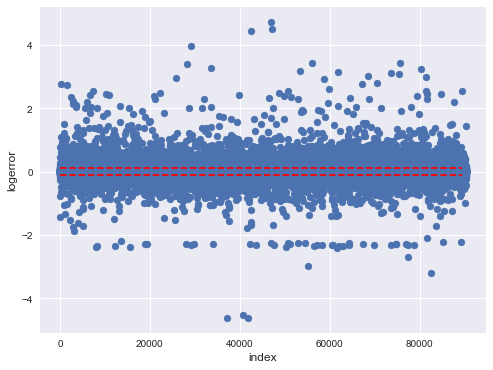

In [33]:
# show the graph of logerror with lines
plt.figure(figsize=(8,6))
plt.scatter(range(logerror_array.shape[0]), np.sort(logerror_array))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
#####horizontal line
cols=hf.shape[0]
steps=100
horiz_line_data = np.array([rmse for i in list(range(steps))])
xs = np.arange(0,cols,(cols/steps))
plt.plot(xs, horiz_line_data, 'r--') 
horiz_line_data = np.array([rmse_neg for i in list(range(steps))])
plt.plot(xs, horiz_line_data, 'r--') 
plt.show()

## Binomial Model

Let's perform classification on 'logerror_highlow'

We will use the Limited-memory Broyden–Fletcher–Goldfarb–Shanno (L-BFGS) algorithm to ensure that this demo can be run in almost all environments.

In [34]:
glm_bi_v1 = H2OGeneralizedLinearEstimator(
                    model_id='glm__bi_v1',            
                    family='binomial',
                    solver='L_BFGS')

In [35]:
y_binary='logerror_highlow'


In [36]:
glm_bi_v1.train(X, y_binary, training_frame=train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [37]:
glm_bi_v1

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  glm__bi_v1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2234589504384685
RMSE: 0.47271444915346994
LogLoss: 0.6332640128269416
Null degrees of freedom: 81198
Residual degrees of freedom: 75207
Null deviance: 111583.6209405093
Residual deviance: 102840.80915506966
AIC: 114824.80915506966
AUC: 0.6427532928875853
pr_auc: 0.6248905795125741
Gini: 0.28550658577517063
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3101948010211503: 


,0,1,Error,Rate
0,3270.0,41790.0,0.9274,(41790.0/45060.0)
1,17.0,36122.0,0.0005,(17.0/36139.0)
Total,3287.0,77912.0,0.5149,(41807.0/81199.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3101948,0.6334359,330.0
max f2,0.2999656,0.8118828,332.0
max f0point5,0.4369864,0.5487036,221.0
max accuracy,0.4754347,0.6130002,172.0
max precision,0.9880326,1.0,0.0
max recall,0.1748224,1.0,364.0
max specificity,0.9880326,1.0,0.0
max absolute_mcc,0.7985921,0.2488978,60.0
max min_per_class_accuracy,0.4309438,0.5884154,230.0
max mean_per_class_accuracy,0.4441490,0.5941733,210.0


Gains/Lift Table: Avg response rate: 44.51 %, avg score: 44.60 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100001,0.8788141,2.2440854,2.2440854,0.9987685,0.8992502,0.9987685,0.8992502,0.0224411,0.0224411,124.4085371,124.4085371
,2,0.0200002,0.8626453,2.2468524,2.2454689,1.0,0.8700046,0.9993842,0.8846274,0.0224688,0.0449099,124.6852431,124.5468901
,3,0.0300004,0.8517865,2.2440854,2.2450077,0.9987685,0.8571908,0.9991790,0.8754818,0.0224411,0.0673511,124.4085371,124.5007724
,4,0.0400005,0.8394413,2.2440854,2.2447771,0.9987685,0.8459307,0.9990764,0.8680941,0.0224411,0.0897922,124.4085371,124.4777136
,5,0.0500006,0.6657080,2.0614594,2.2081136,0.9174877,0.8008453,0.9827586,0.8546443,0.0206148,0.1104070,106.1459435,120.8113596
,6,0.1000012,0.5135524,1.2833623,1.7457379,0.5711823,0.5525037,0.7769704,0.7035740,0.0641689,0.1745759,28.3362263,74.5737929
,7,0.1500018,0.4866759,1.1765538,1.5560099,0.5236453,0.4984883,0.6925287,0.6352121,0.0588284,0.2334044,17.6553761,55.6009873
,8,0.2000025,0.4721866,1.1118046,1.4449585,0.4948276,0.4789059,0.6431034,0.5961356,0.0555909,0.2889953,11.1804565,44.4958546
,9,0.3000037,0.4533620,1.1118046,1.3339072,0.4948276,0.4620539,0.5936782,0.5514417,0.1111818,0.4001771,11.1804565,33.3907219
,10,0.4000049,0.4405716,1.0357104,1.2593580,0.4609606,0.4467127,0.5604988,0.5252594,0.1035723,0.5037494,3.5710425,25.9358020



Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2019-02-20 01:34:28,0.000 sec,0,55791.8104703,0.6870997
,2019-02-20 01:34:28,0.062 sec,1,55540.7363374,0.6840166
,2019-02-20 01:34:28,0.120 sec,2,54203.8316944,0.6690222
,2019-02-20 01:34:28,0.141 sec,3,53427.1974709,0.6612905
,2019-02-20 01:34:28,0.171 sec,4,53326.6581786,0.6602605
,2019-02-20 01:34:28,0.187 sec,5,53041.1392489,0.6575935
,2019-02-20 01:34:28,0.229 sec,6,52124.0933546,0.6503448
,2019-02-20 01:34:28,0.243 sec,7,51956.5070436,0.6484665
,2019-02-20 01:34:28,0.262 sec,8,51696.4244124,0.6469265
,2019-02-20 01:34:28,0.277 sec,9,51602.8539268,0.6465430


In [38]:
dir(glm_bi_v1)

['F0point5',
 'F1',
 'F2',
 'Lambda',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bc',
 '_bcin',
 '_check_and_save_parm',
 '_check_targets',
 '_compute_algo',
 '_end_time',
 '_estimator_type',
 '_future',
 '_get_metrics',
 '_have_mojo',
 '_have_pojo',
 '_id',
 '_is_xvalidated',
 '_job',
 '_keyify_if_h2oframe',
 '_metrics_class',
 '_model_json',
 '_parms',
 '_plot',
 '_requires_training_frame',
 '_resolve_model',
 '_run_time',
 '_start_time',
 '_verify_training_frame_params',
 '_xval_keys',
 'accuracy',
 'actual_params',
 'aic',
 'algo',
 'alpha',
 'auc',
 'balance_classes',
 'beta_constraints',
 'beta_epsilon',
 'biases',
 'catoffsets',
 'class_sa

In [39]:
glm_bi_v1.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3101948010211503: 


,0,1,Error,Rate
0,3270.0,41790.0,0.9274,(41790.0/45060.0)
1,17.0,36122.0,0.0005,(17.0/36139.0)
Total,3287.0,77912.0,0.5149,(41807.0/81199.0)


Confusion Matrix (Act/Pred) for max f2 @ threshold = 0.2999655906020801: 


,0,1,Error,Rate
0,3254.0,41806.0,0.9278,(41806.0/45060.0)
1,12.0,36127.0,0.0003,(12.0/36139.0)
Total,3266.0,77933.0,0.515,(41818.0/81199.0)


Confusion Matrix (Act/Pred) for max f0point5 @ threshold = 0.43698642101660923: 


,0,1,Error,Rate
0,29292.0,15768.0,0.3499,(15768.0/45060.0)
1,16733.0,19406.0,0.463,(16733.0/36139.0)
Total,46025.0,35174.0,0.4003,(32501.0/81199.0)


Confusion Matrix (Act/Pred) for max accuracy @ threshold = 0.4754347403777035: 


,0,1,Error,Rate
0,39777.0,5283.0,0.1172,(5283.0/45060.0)
1,26141.0,9998.0,0.7233,(26141.0/36139.0)
Total,65918.0,15281.0,0.387,(31424.0/81199.0)


Confusion Matrix (Act/Pred) for max precision @ threshold = 0.9880326363197696: 


,0,1,Error,Rate
0,45060.0,0.0,0.0,(0.0/45060.0)
1,36137.0,2.0,0.9999,(36137.0/36139.0)
Total,81197.0,2.0,0.445,(36137.0/81199.0)


Confusion Matrix (Act/Pred) for max recall @ threshold = 0.17482238691356144: 


,0,1,Error,Rate
0,2303.0,42757.0,0.9489,(42757.0/45060.0)
1,0.0,36139.0,0.0,(0.0/36139.0)
Total,2303.0,78896.0,0.5266,(42757.0/81199.0)


Confusion Matrix (Act/Pred) for max precision @ threshold = 0.9880326363197696: 


,0,1,Error,Rate
0,45060.0,0.0,0.0,(0.0/45060.0)
1,36137.0,2.0,0.9999,(36137.0/36139.0)
Total,81197.0,2.0,0.445,(36137.0/81199.0)


Confusion Matrix (Act/Pred) for max absolute_mcc @ threshold = 0.7985921088551544: 


,0,1,Error,Rate
0,45054.0,6.0,0.0001,(6.0/45060.0)
1,32281.0,3858.0,0.8932,(32281.0/36139.0)
Total,77335.0,3864.0,0.3976,(32287.0/81199.0)


Confusion Matrix (Act/Pred) for max min_per_class_accuracy @ threshold = 0.43094382581115653: 


,0,1,Error,Rate
0,26514.0,18546.0,0.4116,(18546.0/45060.0)
1,14729.0,21410.0,0.4076,(14729.0/36139.0)
Total,41243.0,39956.0,0.4098,(33275.0/81199.0)


Confusion Matrix (Act/Pred) for max mean_per_class_accuracy @ threshold = 0.4441490224921936: 


,0,1,Error,Rate
0,32015.0,13045.0,0.2895,(13045.0/45060.0)
1,18870.0,17269.0,0.5222,(18870.0/36139.0)
Total,50885.0,30314.0,0.393,(31915.0/81199.0)


[, , , , , , , , , ]

In [40]:
glm_bi_v1.params

{'alpha': {'actual': [0.0], 'default': None},
 'balance_classes': {'actual': False, 'default': False},
 'beta_constraints': {'actual': None, 'default': None},
 'beta_epsilon': {'actual': 0.0001, 'default': 0.0001},
 'class_sampling_factors': {'actual': None, 'default': None},
 'compute_p_values': {'actual': False, 'default': False},
 'custom_metric_func': {'actual': None, 'default': None},
 'early_stopping': {'actual': True, 'default': True},
 'export_checkpoints_dir': {'actual': None, 'default': None},
 'family': {'actual': 'binomial', 'default': 'gaussian'},
 'fold_assignment': {'actual': 'AUTO', 'default': 'AUTO'},
 'fold_column': {'actual': None, 'default': None},
 'gradient_epsilon': {'actual': 0.0001, 'default': -1.0},
 'ignore_const_cols': {'actual': True, 'default': True},
 'ignored_columns': {'actual': ['logerror'], 'default': None},
 'interaction_pairs': {'actual': None, 'default': None},
 'interactions': {'actual': None, 'default': None},
 'intercept': {'actual': True, 'defa

## The First Multinomial Model

Our goal is to perform classification on logerror_three

In [41]:
glm_multi_v1 = H2OGeneralizedLinearEstimator(
                    model_id='glm_multi_v1',            
                    family='multinomial',
                    solver='L_BFGS')

In [42]:
y_multi='logerror_three'

In [43]:
train['logerror_three'].table()

logerror_three,Count
0,3279
1,74065
2,3855


In [44]:
glm_multi_v1.train(X, y_multi, training_frame=train,validation_frame=valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [45]:
glm_multi_v1

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  glm_multi_v1


ModelMetricsMultinomialGLM: glm
** Reported on train data. **

MSE: 0.0782950686954553
RMSE: 0.27981255993156434

ModelMetricsMultinomialGLM: glm
** Reported on validation data. **

MSE: 0.0771305207836345
RMSE: 0.2777238210590415
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2019-02-20 01:34:31,0.000 sec,0,29082.7475273,0.3581663
,2019-02-20 01:34:31,0.245 sec,1,27591.4464804,0.3401143
,2019-02-20 01:34:31,0.526 sec,2,26794.2602264,0.3308572
,2019-02-20 01:34:31,0.661 sec,3,25894.0745051,0.3210827
,2019-02-20 01:34:31,0.717 sec,4,25257.3993601,0.3151848
,2019-02-20 01:34:32,0.801 sec,5,24511.5909341,0.3067779
,2019-02-20 01:34:32,0.919 sec,6,23974.7551035,0.3022854
,2019-02-20 01:34:32,1.012 sec,7,23634.9022172,0.2998932
,2019-02-20 01:34:32,1.103 sec,8,23479.9972365,0.2990673
,2019-02-20 01:34:32,1.188 sec,9,23376.0079610,0.2985514


In [46]:
glm_multi_v1.hit_ratio_table(valid=True)

Top-3 Hit Ratios: 


k,hit_ratio
1,0.9143896
2,0.9997796
3,1.0


In [47]:
glm_multi_v1.confusion_matrix(data=valid)

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,Error,Rate
0.0,337.0,0.0,1.0,337 / 337
3.0,8299.0,0.0,0.0003614,"3 / 8,302"
0.0,437.0,0.0,1.0,437 / 437
3.0,9073.0,0.0,0.0856104,"777 / 9,076"


## Regularization

alpha

You choose lasso regression by setting alpha to 1.0, and you choose ridge regression by setting alpha to 0.0.


lambda

Regularization strength. The default is chosen based on lambda max it is often useful to try lambda search to automatically find a good value. If you want to explicitly choose values for lambda that lambda search should try, specify them as a list here.


lambda_search
If true, then it will try multiple values of lambda for you.



In [48]:
glm_gaussian_ridge_v1= H2OGeneralizedLinearEstimator(
                    model_id='glm_gaussian_ridge_v1',           
                    family='gaussian',
                    solver='L_BFGS',
                    alpha=0.0,
                    lambda_search=True, 
                    nlambdas=55      
)

In [49]:
glm_gaussian_ridge_v1.train(X, y, training_frame=train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [50]:
glm_gaussian_ridge_v1

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  glm_gaussian_ridge_v1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.012203493286508117
RMSE: 0.11046942240506247
MAE: 0.042285870464095945
RMSLE: NaN
R^2: 0.5247600916566801
Mean Residual Deviance: 0.012203493286508117
Null degrees of freedom: 81198
Residual degrees of freedom: 75205
Null deviance: 2085.076261430717
Residual deviance: 990.9114513711726
AIC: -115342.69635305945
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2019-02-20 01:34:34,0.000 sec,4,.34E1,5994,0.0484573,nan
,2019-02-20 01:34:34,0.088 sec,7,.29E1,5994,0.0480235,nan
,2019-02-20 01:34:34,0.127 sec,9,.24E1,5994,0.0475509,nan
,2019-02-20 01:34:35,0.166 sec,11,.21E1,5994,0.0470225,nan
,2019-02-20 01:34:35,0.206 sec,13,.17E1,5994,0.0464490,nan
---,---,---,---,---,---,---,---
,2019-02-20 01:34:39,4.495 sec,195,.19E-2,5994,0.0244094,nan
,2019-02-20 01:34:39,4.587 sec,196,.16E-2,5994,0.0244090,nan
,2019-02-20 01:34:39,4.609 sec,197,.13E-2,5994,0.0244084,nan
,2019-02-20 01:34:39,4.671 sec,198,.11E-2,5994,0.0244078,nan



See the whole table with table.as_data_frame()


In [51]:
dir(glm_gaussian_ridge_v1)

['Lambda',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bc',
 '_bcin',
 '_check_and_save_parm',
 '_check_targets',
 '_compute_algo',
 '_end_time',
 '_estimator_type',
 '_future',
 '_get_metrics',
 '_have_mojo',
 '_have_pojo',
 '_id',
 '_is_xvalidated',
 '_job',
 '_keyify_if_h2oframe',
 '_make_model',
 '_metrics_class',
 '_model_json',
 '_parms',
 '_plot',
 '_requires_training_frame',
 '_resolve_model',
 '_run_time',
 '_start_time',
 '_verify_training_frame_params',
 '_xval_keys',
 'actual_params',
 'aic',
 'algo',
 'alpha',
 'auc',
 'balance_classes',
 'beta_constraints',
 'beta_epsilon',
 'biases',
 'catoffsets',
 'class_sampling_factors',
 'coef'

In [52]:
glm_gaussian_ridge_v1.params

{'alpha': {'actual': [0.0], 'default': None},
 'balance_classes': {'actual': False, 'default': False},
 'beta_constraints': {'actual': None, 'default': None},
 'beta_epsilon': {'actual': 0.0001, 'default': 0.0001},
 'class_sampling_factors': {'actual': None, 'default': None},
 'compute_p_values': {'actual': False, 'default': False},
 'custom_metric_func': {'actual': None, 'default': None},
 'early_stopping': {'actual': True, 'default': True},
 'export_checkpoints_dir': {'actual': None, 'default': None},
 'family': {'actual': 'gaussian', 'default': 'gaussian'},
 'fold_assignment': {'actual': 'AUTO', 'default': 'AUTO'},
 'fold_column': {'actual': None, 'default': None},
 'gradient_epsilon': {'actual': 1.0000000000000002e-06, 'default': -1.0},
 'ignore_const_cols': {'actual': True, 'default': True},
 'ignored_columns': {'actual': None, 'default': None},
 'interaction_pairs': {'actual': None, 'default': None},
 'interactions': {'actual': None, 'default': None},
 'intercept': {'actual': Tru

In [53]:
rmse=glm_gaussian_v1.rmse()
print(rmse)
rmse_neg=(-1*rmse)
print(rmse_neg)
ridge_rsme=glm_gaussian_ridge_v1.rmse()
print(ridge_rsme)
ridge_rsme_neg=(-1*ridge_rsme)
print(ridge_rsme_neg)

0.11076795336177944
-0.11076795336177944
0.11046942240506247
-0.11046942240506247


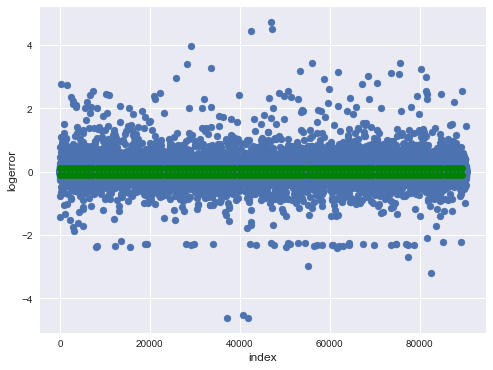

In [54]:
# show the graph of logerror with lines
plt.figure(figsize=(8,6))
plt.scatter(range(logerror_array.shape[0]), np.sort(logerror_array))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
#####horizontal line
cols=hf.shape[0]
steps=100
xs = np.arange(0,cols,(cols/steps))
horiz_line_data = np.array([rmse for i in list(range(steps))])
plt.plot(xs, horiz_line_data, 'r--') 
horiz_line_data = np.array([rmse_neg for i in list(range(steps))])
plt.plot(xs, horiz_line_data, 'r--') 
horiz_line_data = np.array([ridge_rsme for i in list(range(steps))])
plt.plot(xs, horiz_line_data, 'go') 
horiz_line_data = np.array([ridge_rsme_neg for i in list(range(steps))])
plt.plot(xs, horiz_line_data, 'go') 
plt.show()

In [55]:
def gen_lambda(n):
  l=np.linspace(0.1, 999.0, num=555)
  indices = random.sample(range(len(l)), n)
  lam=[l[i] for i in sorted(indices)] 
  lam.insert(0,0.0)
  lam.append(1000.0)
  return lam

In [58]:
lambd=gen_lambda(99)
print(lambd[:9])

[0.0, 12.72148014440433, 14.524548736462092, 21.736823104693141, 25.342960288808662, 30.752166064981949, 43.37364620938628, 65.010469314079415, 66.813537906137171]


In [59]:
# select the values for lambda_ to grid over
hyper_params = {'lambda': lambd}

In [60]:
# import Grid Search
from h2o.grid.grid_search import H2OGridSearch

In [61]:
glm_gaussian_ridge_v2= H2OGeneralizedLinearEstimator(
                    model_id='glm_gaussian_ridge_v2',           
                    family='gaussian',
                    solver='L_BFGS',
                    alpha=0.0
)

In [62]:
# build grid search with previously made GLM and hyperparameters
grid = H2OGridSearch(model = glm_gaussian_ridge_v2, hyper_params = hyper_params,
                     search_criteria = {'strategy': "Cartesian"})

In [63]:
# train using the grid
grid.train(x = X, y = y, training_frame = train, validation_frame = valid)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [64]:
# sort the grid models by decreasing AUC
sorted_grid = grid.get_grid(sort_by = 'rmse', decreasing = True)

                      lambda  \
0                   [1000.0]   
1        [997.1969314079422]   
2        [961.1355595667869]   
3        [950.3171480144404]   
4        [943.1048736462093]   
5         [923.271119133574]   
6        [916.0588447653429]   
7        [907.0435018050541]   
8        [905.2404332129963]   
9        [901.6342960288808]   
10       [896.2250902527076]   
11       [874.5882671480144]   
12       [829.5115523465704]   
13       [820.4962093862815]   
14        [816.890072202166]   
15       [811.4808664259928]   
16       [797.0563176895306]   
17       [791.6471119133573]   
18       [784.4348375451264]   
19       [779.0256317689531]   
20       [751.9796028880866]   
21       [742.9642599277978]   
22       [735.7519855595667]   
23       [732.1458483754512]   
24       [728.5397111913358]   
25       [721.3274368231047]   
26       [710.5090252707581]   
27       [694.2814079422383]   
28       [685.2660649819494]   
29       [681.6599277978339]   
..  ..  

In [68]:
sorted_grid

                      lambda  \
0                   [1000.0]   
1        [997.1969314079422]   
2        [961.1355595667869]   
3        [950.3171480144404]   
4        [943.1048736462093]   
5         [923.271119133574]   
6        [916.0588447653429]   
7        [907.0435018050541]   
8        [905.2404332129963]   
9        [901.6342960288808]   
10       [896.2250902527076]   
11       [874.5882671480144]   
12       [829.5115523465704]   
13       [820.4962093862815]   
14        [816.890072202166]   
15       [811.4808664259928]   
16       [797.0563176895306]   
17       [791.6471119133573]   
18       [784.4348375451264]   
19       [779.0256317689531]   
20       [751.9796028880866]   
21       [742.9642599277978]   
22       [735.7519855595667]   
23       [732.1458483754512]   
24       [728.5397111913358]   
25       [721.3274368231047]   
26       [710.5090252707581]   
27       [694.2814079422383]   
28       [685.2660649819494]   
29       [681.6599277978339]   
..  ..  

In [ ]:
h2o.cluster().shutdown()